In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from advopt import tasks
from advopt.target.utils import combine

In [2]:
task = tasks.SwissRoll()
assert len(task.search_space()) == 1, 'This example only works for 1D search space.'

params = np.linspace(task.search_space()[0][0], task.search_space()[0][1], num=51)

clf_type = 'NN'
size = 8 * 1024

In [3]:
### to obtain smooth curves we reuse the same data
### the same effect can be achieved by averaging curves over multiple runs.

data_pos = task.ground_truth_generator()(size)
data_pos_test = task.ground_truth_generator()(size)

if task.is_synthetic():
    data_neg_0 = task.ground_truth_generator()(size)
    data_neg_test_0 = task.ground_truth_generator()(size)
else:
    data_neg_0 = None
    data_neg_test_0 = None

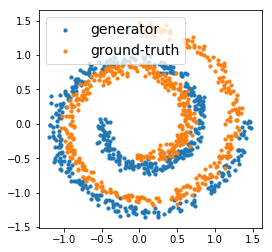

In [4]:
try:
    d_pos = task.ground_truth_generator()(size)
    d_neg = task.generator(task.example_parameters())(size)
    
    plt.figure(figsize=(4, 4))
    plt.scatter(d_neg[:512, 0], d_neg[:512, 1], label='generator', s=10)
    plt.scatter(d_pos[:512, 0], d_pos[:512, 1], label='ground-truth', s=10)
    plt.legend(loc='upper left', fontsize=14)
    plt.savefig('%s-example.pdf' % (task.name(), ))
except:
    pass

In [5]:
param = np.pi / 4
if task.is_synthetic():
    data_neg = task.transform(data_neg_0, [param])
    data_neg_test = task.transform(data_neg_test_0, [param])
else:
    data_neg = task.generator([param])(size)
    data_neg_test = task.generator([param])(size)

In [6]:
data, labels = combine(data_pos, data_neg)
data = data.astype('float32')

In [7]:
import torch

In [8]:
import torch
from torch import nn

class Net(nn.Module):
  def __init__(self, ndim):
    super(Net, self).__init__()
    
    self.layer1 = nn.Linear(in_features=ndim, out_features=1024)
    self.layer2 = nn.Linear(in_features=1024, out_features=512)
    self.layer3 = nn.Linear(in_features=512, out_features=1)

    self.activation = nn.Softplus()

  def forward(self, X):
    X1 = self.activation(self.layer1(X))
    X2 = self.activation(self.layer2(X1))
    return torch.squeeze(self.layer3(X2), dim=1)

In [9]:
device = 'cuda:0'

In [10]:
from advopt import GradNetwork

In [11]:
net = GradNetwork(Net(2), device='cuda:0', grad_penalty=1e-1, stop_criterion=32)

In [12]:
net.fit(data, labels, progress=tqdm)

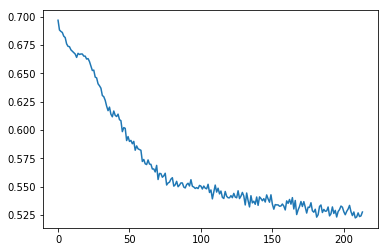

In [13]:
plt.plot(net.loss_history())

In [14]:
def predict_grid(space, steps=20):
    xs = tuple([
      np.linspace(lower_x, upper_x, num=steps)
      for lower_x, upper_x in space
    ])

    grids = np.meshgrid(*xs)
    X = np.vstack([grid.reshape(-1) for grid in grids]).T.astype('float32')

    proba = net.predict_proba(X, flatten=True)
    proba = proba.reshape((steps, ) * len(space))

    return xs, proba

In [15]:
(xs, ys), Z = predict_grid([(-1.5, 1.5), (-1.5, 1.5)])

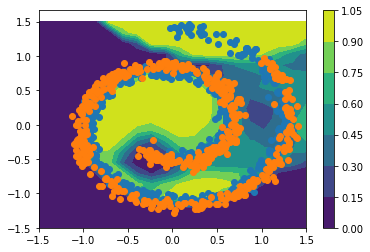

In [16]:
plt.contourf(xs, ys, Z)
plt.colorbar()
plt.scatter(data_pos[:512, 0], data_pos[:512, 1])
plt.scatter(data_neg[:512, 0], data_neg[:512, 1])